In [ ]:
from google.colab import drive

In [ ]:
#!python --version
#!pip show matplotlib
#!pip show scikit-learn
#!pip show keras
#!pip show tensorflow
! nvidia-smi

Sat Feb 25 03:27:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/Midterm Thesis/dataset/DATASET15.zip', 'r')
zip_ref.extractall('/content/maindataset')
zip_ref.close()

In [ ]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
#from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread, imshow
from keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_path = '/content/maindataset/DATASET15/TRAIN'
test_path = '/content/maindataset/DATASET15/TEST'

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['O', 'R'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['O', 'R'], batch_size=10)


Found 21504 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


In [ ]:
# plot function, used to plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


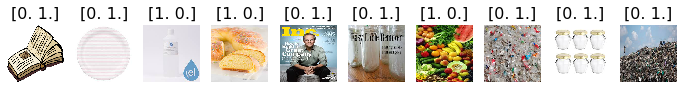

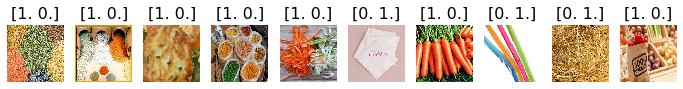

In [ ]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)
imgs, labels = next(test_batches)
plots(imgs, titles=labels)

### **Data Augmentation**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2, 
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                rescale=1./255, validation_split=0.15)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_path, class_mode = 'binary',
                                              batch_size = 32, 
                                              target_size=(224,224), subset='training')

val_set = train_datagen.flow_from_directory(train_path, class_mode = 'binary',
                                              batch_size = 32, 
                                              target_size=(224,224), subset='validation')

test_set = test_datagen.flow_from_directory(test_path, class_mode = 'binary',
                                              batch_size = 32, 
                                              target_size=(224,224))


Found 18279 images belonging to 2 classes.
Found 3225 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


## Convolution Block

In [ ]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    return x

## Creating Model

In [ ]:
def create_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    x = conv_block(inputs, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
        
    x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
    
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    func_model = tf.keras.models.Model(inputs = inputs, outputs=output)
    
    return func_model

In [ ]:
model = create_model()

## Compiling and fitting data

In [ ]:
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
             
    ]
adam = tf.keras.optimizers.Adam()    
model.compile(optimizer = adam, loss ='binary_crossentropy', metrics = METRICS)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3
                                                  , patience=5, verbose=2, 
                                                  mode='max')
# Define the checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='cnnfinal_model_weights.h5', save_best_only=True)

history = model.fit(train_set, validation_data = val_set, epochs =30, 
                    callbacks=[lr_reduce, checkpoint_callback])



Epoch 1/30
572/572 [==============================] - 303s 506ms/step - loss: 2.7502 - accuracy: 0.7810 - tp: 5969.0000 - fp: 1827.0000 - tn: 8307.0000 - fn: 2176.0000 - precision: 0.7656 - recall: 0.7328 - val_loss: 0.4974 - val_accuracy: 0.7442 - val_tp: 679.0000 - val_fp: 67.0000 - val_tn: 1721.0000 - val_fn: 758.0000 - val_precision: 0.9102 - val_recall: 0.4725 - lr: 0.0010
Epoch 2/30
572/572 [==============================] - 286s 500ms/step - loss: 0.4449 - accuracy: 0.8078 - tp: 6157.0000 - fp: 1526.0000 - tn: 8608.0000 - fn: 1988.0000 - precision: 0.8014 - recall: 0.7559 - val_loss: 0.5465 - val_accuracy: 0.7098 - val_tp: 745.0000 - val_fp: 244.0000 - val_tn: 1544.0000 - val_fn: 692.0000 - val_precision: 0.7533 - val_recall: 0.5184 - lr: 0.0010
Epoch 3/30
572/572 [==============================] - 271s 474ms/step - loss: 0.4343 - accuracy: 0.8145 - tp: 6336.0000 - fp: 1581.0000 - tn: 8553.0000 - fn: 1809.0000 - precision: 0.8003 - recall: 0.7779 - val_loss: 0.5055 - val_accurac

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496 

In [ ]:
model.evaluate(test_set)

112/112 [==============================] - 9s 77ms/step - loss: 0.2866 - accuracy: 0.8894 - tp: 1318.0000 - fp: 184.0000 - tn: 1860.0000 - fn: 211.0000 - precision: 0.8775 - recall: 0.8620


[0.28655004501342773,
 0.8894486427307129,
 1318.0,
 184.0,
 1860.0,
 211.0,
 0.8774966597557068,
 0.8620012998580933]

In [ ]:
test_loss, test_acc, true_positives, false_positives, true_negatives, false_negatives, precision, recall = model.evaluate(test_set)


112/112 [==============================] - 7s 64ms/step - loss: 0.2866 - accuracy: 0.8894 - tp: 1318.0000 - fp: 184.0000 - tn: 1860.0000 - fn: 211.0000 - precision: 0.8775 - recall: 0.8620


In [ ]:
# Compute the confusion matrix
confusion_mtx = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

print(confusion_mtx)


[[1860.  184.]
 [ 211. 1318.]]


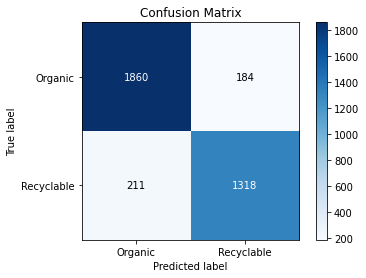

In [ ]:
# Define the class names for the matrix
class_names = ['Organic', 'Recyclable']

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for the chart
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations to the chart
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()


# Plot

Text(0.5, 1.0, 'Training and validation loss')

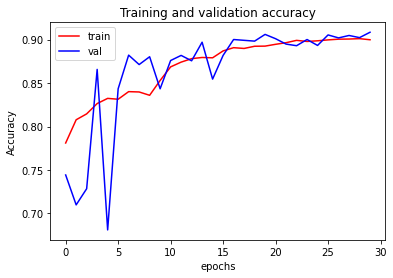

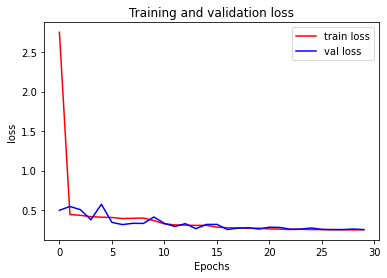

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
#print(history.history['lr'])
epochs=range(len(acc)) # Get number of epochs
rec = history.history['recall']
per = history.history['precision']
val_rec = history.history['val_recall']
val_perc = history.history['val_precision']


# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

## vgg16 Model Building

In [ ]:
from keras.applications.vgg16 import VGG16
#vgg16_model = VGG16()

In [ ]:
# Defining Model
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers 
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.15)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.15)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_set  = train_datagen.flow_from_directory(train_path,
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

val_set = valid_datagen.flow_from_directory(train_path,
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')
test_set = test_datagen.flow_from_directory(test_path, class_mode = 'binary',
                                              batch_size = 128, 
                                              target_size=(224, 224))

Found 18279 images belonging to 2 classes.
Found 3225 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


In [ ]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1024)              25691136  
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [ ]:
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
          tf.metrics.AUC(name='auc')
          
    ]
# Model Compile 
OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              metrics= METRICS,
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './vgg_final_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Fitting 
model_history=model.fit(train_set,
                        validation_data=val_set,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8645 - tp: 6833.0000 - fp: 1165.0000 - tn: 8969.0000 - fn: 1312.0000 - precision: 0.8543 - recall: 0.8389 - auc: 0.9324
Epoch 1: val_auc improved from -inf to 0.95002, saving model to ./vgg_final_best_weights.hdf5
143/143 [==============================] - 269s 2s/step - loss: 0.3406 - accuracy: 0.8645 - tp: 6833.0000 - fp: 1165.0000 - tn: 8969.0000 - fn: 1312.0000 - precision: 0.8543 - recall: 0.8389 - auc: 0.9324 - val_loss: 0.3048 - val_accuracy: 0.8809 - val_tp: 1149.0000 - val_fp: 96.0000 - val_tn: 1692.0000 - val_fn: 288.0000 - val_precision: 0.9229 - val_recall: 0.7996 - val_auc: 0.9500
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9016 - tp: 7198.0000 - fp: 852.0000 - tn: 9282.0000 - fn: 947.0000 - precision: 0.8942 - recall: 0.8837 - auc: 0.9601
Epoch 2: val_auc improved from 0.95002 to 0.95855, saving model to ./vgg_final_best_weights.hdf5
14

In [ ]:
model.evaluate(test_set)

28/28 [==============================] - 24s 857ms/step - loss: 0.3893 - accuracy: 0.8687 - tp: 1185.0000 - fp: 125.0000 - tn: 1919.0000 - fn: 344.0000 - precision: 0.9046 - recall: 0.7750 - auc: 0.9347


[0.38929203152656555,
 0.8687377572059631,
 1185.0,
 125.0,
 1919.0,
 344.0,
 0.9045801758766174,
 0.7750163674354553,
 0.934738278388977]

In [ ]:
test_loss, test_acc, true_positives, false_positives, true_negatives, false_negatives, precision, recall, auc = model.evaluate(test_set)

28/28 [==============================] - 15s 537ms/step - loss: 0.3893 - accuracy: 0.8687 - tp: 1185.0000 - fp: 125.0000 - tn: 1919.0000 - fn: 344.0000 - precision: 0.9046 - recall: 0.7750 - auc: 0.9347


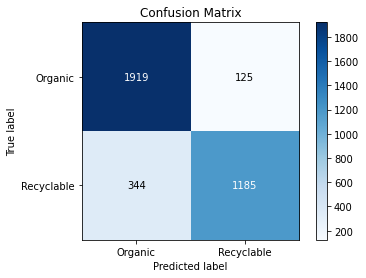

In [ ]:
# Compute the confusion matrix
confusion_mtx = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
# Define the class names for the matrix
class_names = ['Organic', 'Recyclable']

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for the chart
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations to the chart
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()

Text(0.5, 1.0, 'Training and validation loss')

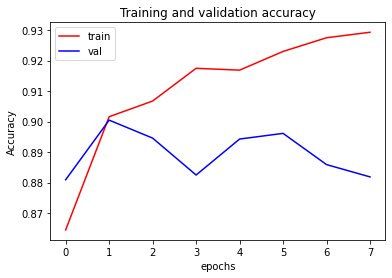

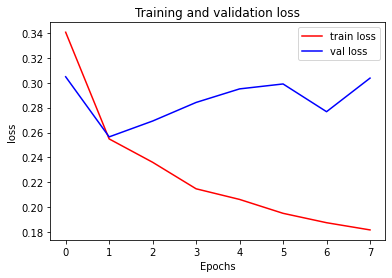

In [ ]:
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

In [ ]:
# Class Indices 
train_set.class_indices

{'O': 0, 'R': 1}

1/1 [==============================] - 1s 963ms/step
The image belongs to Organic waste category 


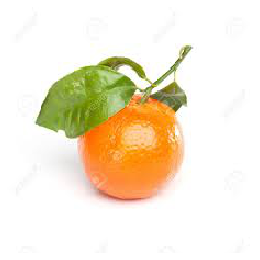

In [ ]:
# Test Case:1 - ORGANIC

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/O/O_15.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 28ms/step
The image belongs to Recycle waste category


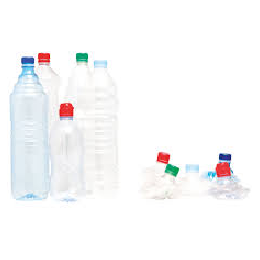

In [ ]:
# Test Case:2 - RECYCLE

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/R/R_78.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

# Improving Model Performances

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.15)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.15)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_set  = train_datagen.flow_from_directory(train_path,
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

val_set = valid_datagen.flow_from_directory(train_path,
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')
test_set = test_datagen.flow_from_directory(test_path, class_mode = 'binary',
                                              batch_size = 128, 
                                              target_size=(224, 224))

Found 18279 images belonging to 2 classes.
Found 3225 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


In [ ]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
          tf.metrics.AUC(name='auc')
          
    ]
# Model Compile 
OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              metrics= METRICS,
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './vgg_fnl_afterimprv_best_weights_imp.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Fitting 
model_history=model.fit(train_set,
                        validation_data=val_set,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
143/143 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8584 - tp: 6820.0000 - fp: 1263.0000 - tn: 8871.0000 - fn: 1325.0000 - precision: 0.8437 - recall: 0.8373 - auc: 0.9259
Epoch 1: val_auc improved from -inf to 0.92696, saving model to ./vgg_fnl_afterimprv_best_weights_imp.hdf5
143/143 [==============================] - 286s 2s/step - loss: 0.3587 - accuracy: 0.8584 - tp: 6820.0000 - fp: 1263.0000 - tn: 8871.0000 - fn: 1325.0000 - precision: 0.8437 - recall: 0.8373 - auc: 0.9259 - val_loss: 0.3643 - val_accuracy: 0.8431 - val_tp: 1282.0000 - val_fp: 351.0000 - val_tn: 1437.0000 - val_fn: 155.0000 - val_precision: 0.7851 - val_recall: 0.8921 - val_auc: 0.9270
Epoch 2/10
143/143 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8887 - tp: 7100.0000 - fp: 990.0000 - tn: 9144.0000 - fn: 1045.0000 - precision: 0.8776 - recall: 0.8717 - auc: 0.9526
Epoch 2: val_auc improved from 0.92696 to 0.95677, saving model to ./vgg_fnl_afterim

In [ ]:
model.evaluate(test_set)

28/28 [==============================] - 24s 845ms/step - loss: 0.3508 - accuracy: 0.8777 - tp: 1234.0000 - fp: 142.0000 - tn: 1902.0000 - fn: 295.0000 - precision: 0.8968 - recall: 0.8071 - auc: 0.9390


[0.3508490025997162,
 0.8776938319206238,
 1234.0,
 142.0,
 1902.0,
 295.0,
 0.8968023061752319,
 0.8070634603500366,
 0.9390442371368408]

In [ ]:
# Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [ ]:
test_loss, test_acc, true_positives, false_positives, true_negatives, false_negatives, precision, recall, auc = model.evaluate(test_set)

28/28 [==============================] - 15s 525ms/step - loss: 0.3508 - accuracy: 0.8777 - tp: 1234.0000 - fp: 142.0000 - tn: 1902.0000 - fn: 295.0000 - precision: 0.8968 - recall: 0.8071 - auc: 0.9390


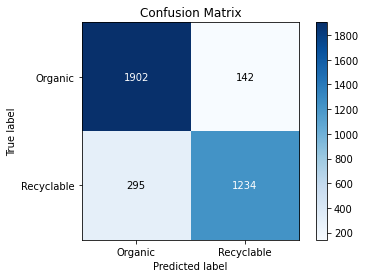

In [ ]:
# Compute the confusion matrix
confusion_mtx = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
# Define the class names for the matrix
class_names = ['Organic', 'Recyclable']

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for the chart
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations to the chart
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()

Text(0.5, 1.0, 'Training and validation loss')

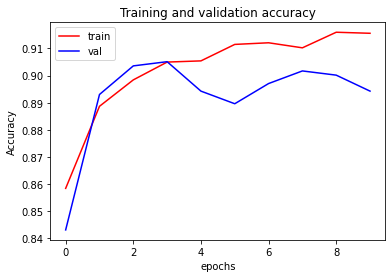

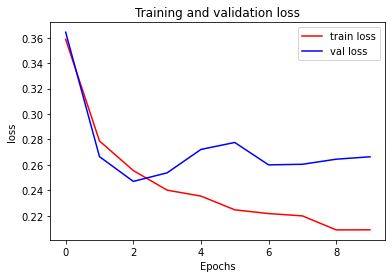

In [ ]:
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

In [ ]:
# Class Indices 
train_set.class_indices

In [ ]:
# Test Case:1 - ORGANIC

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/O/O_15.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [ ]:
# Test Case:2 - RECYCLE

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/R/R_78.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [ ]:
def f1_score(precision, recall):
    """Calculate the F1 score given the precision and recall values."""
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [ ]:
precision = 0.8825
recall = 0.8834
f1 = f1_score(precision, recall)
print("F1 score: ", f1)

# ResNet50 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# Defining Model
base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
# Freezing Layers 
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Summary
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
train_datagen_resnet50 = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                    width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.15)

valid_datagen_resnet50 = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.15)

test_datagen_resnet50  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_set_resnet  = train_datagen_resnet50.flow_from_directory(train_path,
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

val_set_resnet = valid_datagen_resnet50.flow_from_directory(train_path,
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')
test_set_resnet = test_datagen_resnet50.flow_from_directory(test_path, class_mode = 'binary',
                                              batch_size = 128, 
                                              target_size=(224, 224))

Found 18279 images belonging to 2 classes.
Found 3225 images belonging to 2 classes.
Found 3573 images belonging to 2 classes.


In [ ]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1024)              102761472 
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [ ]:
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
          tf.metrics.AUC(name='auc')
          
    ]
# Model Compile 
OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              metrics= METRICS,
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './reset50_final_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Fitting 
model_history=model.fit(train_set_resnet50,
                        validation_data=val_set_resnet50,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
572/572 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7213 - tp: 5342.0000 - fp: 2292.0000 - tn: 7842.0000 - fn: 2803.0000 - precision: 0.6998 - recall: 0.6559 - auc: 0.7840
Epoch 1: val_auc improved from -inf to 0.76364, saving model to ./reset50_final_best_weights.hdf5
572/572 [==============================] - 329s 563ms/step - loss: 0.5809 - accuracy: 0.7213 - tp: 5342.0000 - fp: 2292.0000 - tn: 7842.0000 - fn: 2803.0000 - precision: 0.6998 - recall: 0.6559 - auc: 0.7840 - val_loss: 0.6417 - val_accuracy: 0.7039 - val_tp: 795.0000 - val_fp: 313.0000 - val_tn: 1475.0000 - val_fn: 642.0000 - val_precision: 0.7175 - val_recall: 0.5532 - val_auc: 0.7636
Epoch 2/10
572/572 [==============================] - ETA: 0s - loss: 0.5201 - accuracy: 0.7506 - tp: 5685.0000 - fp: 2099.0000 - tn: 8035.0000 - fn: 2460.0000 - precision: 0.7303 - recall: 0.6980 - auc: 0.8220
Epoch 2: val_auc improved from 0.76364 to 0.81997, saving model to ./reset50_final_best_we

In [ ]:
model.evaluate(test_set_resnet)

28/28 [==============================] - 16s 488ms/step - loss: 0.5515 - accuracy: 0.7487 - tp: 1130.0000 - fp: 499.0000 - tn: 1545.0000 - fn: 399.0000 - precision: 0.6937 - recall: 0.7390 - auc: 0.8161


[0.5514587163925171,
 0.7486705780029297,
 1130.0,
 499.0,
 1545.0,
 399.0,
 0.6936771273612976,
 0.7390451431274414,
 0.8161332011222839]

In [ ]:
test_loss, test_acc, true_positives, false_positives, true_negatives, false_negatives, precision, recall, auc = model.evaluate(test_set_resnet)

28/28 [==============================] - 18s 614ms/step - loss: 0.5515 - accuracy: 0.7487 - tp: 1130.0000 - fp: 499.0000 - tn: 1545.0000 - fn: 399.0000 - precision: 0.6937 - recall: 0.7390 - auc: 0.8161


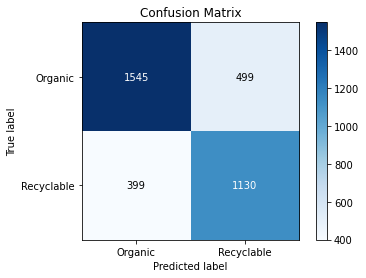

In [ ]:
# Compute the confusion matrix
confusion_mtx = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
# Define the class names for the matrix
class_names = ['Organic', 'Recyclable']

# Plot the confusion matrix as an image
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for the chart
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add annotations to the chart
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")

plt.show()

Text(0.5, 1.0, 'Training and validation loss')

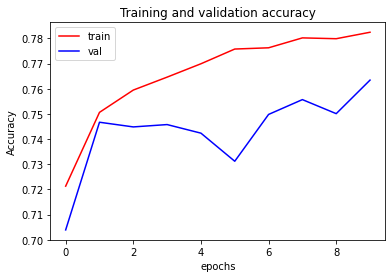

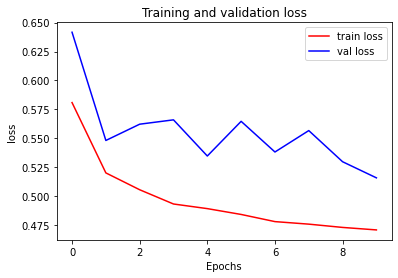

In [ ]:
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

In [ ]:
# Class Indices 
train_set.class_indices

{'O': 0, 'R': 1}

1/1 [==============================] - 2s 2s/step
The image belongs to Organic waste category 


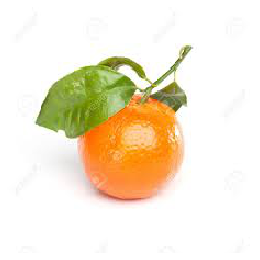

In [ ]:
# Test Case:1 - ORGANIC

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/O/O_15.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 37ms/step
The image belongs to Recycle waste category


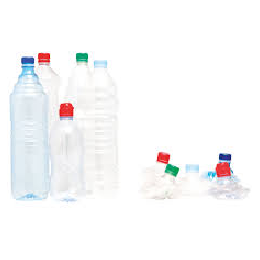

In [ ]:
# Test Case:2 - RECYCLE

dic = test_set.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/maindataset/DATASET15/TEST/R/R_78.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [ ]:
!cp "/content/cnnfinal_model_weights.h5" "/content/drive/MyDrive/Thesis/Midterm Thesis/dataset/"

In [ ]:
!cp "/content/reset50_final_best_weights.hdf5" "/content/drive/MyDrive/Thesis/Midterm Thesis/dataset/"